# Regression Analysis Diagnostics Viz

In this notebook I want to collect some useful visualizations which can help model development and model evaluation in the context of regression analysis. I use many visualization resources not just only to share results but as a key component of my workflow: data QA, EDA, feature engineering, model development, model evaluation and communicating results. In this notebook I focus on a simple regression model (time series) with [statsmodels](https://www.statsmodels.org/stable/index.html) and visualization with [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/index.html). The focus is not on the model development but rather visualization.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

**Remark:** I usually store the [seaborn palette](https://seaborn.pydata.org/tutorial/color_palettes.html) as a list `sns_c` which allows me to select colors efficiently.

## Generate Sample Data

We begin by generating a sample data for our analysis:

In [2]:
np.random.seed(42)

def generate_sample_data():
    """Generate sample time series data."""
    df = pd.DataFrame(
        data={'date': pd.date_range(start='2018-01-01', end='2020-12-31', freq='W')}
    )

    n = df.shape[0]

    df['t'] = np.linspace(start=1, stop=n, num=n)
    df['x1'] = np.random.uniform(low=-1.0, high=1.0, size=n)
    df['x1'] = df['x1'].apply(lambda x: x if abs(x) > 0.7 else 0.0)
    df['x2'] = 10*np.log(df['t'])
    df['x3'] = np.random.uniform(low=-1.0, high=1.0, size=n)
    df['x3'] = df['x3'].apply(lambda x: x if abs(x) > 0.95 else 0.0)
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofyear_sc'] = np.sin(2*np.pi*df['dayofyear']/365.5)
    df['dayofyear_cc'] = np.cos(2*np.pi*df['dayofyear']/365.5)
    df['y'] = 10.0 \
         + 20*df['x1'] \
         + df['x2'] \
         + 15*df['dayofyear_sc'] \
         + 5*df['dayofyear_cc'] + \
         + 10*df['x3'] \
         + np.random.normal(loc=0.0, scale=5.0, size=n)

    return df

data_df = generate_sample_data()

data_df = data_df[['date', 'y', 'x1', 'x2', 'dayofyear_sc', 'dayofyear_cc']]

data_df.head()

,date,y,x1,x2,dayofyear_sc,dayofyear_cc
0,2018-01-07,19.289445,0.000000,0.000000,0.120044,0.992769
1,2018-01-14,47.720002,0.901429,6.931472,0.238353,0.971179
2,2018-01-21,24.960557,0.000000,10.986123,0.353214,0.935543
3,2018-01-28,33.566807,0.000000,13.862944,0.462966,0.886376
4,2018-02-04,36.331939,0.000000,16.094379,0.566022,0.824390


Let us plot the target variable:

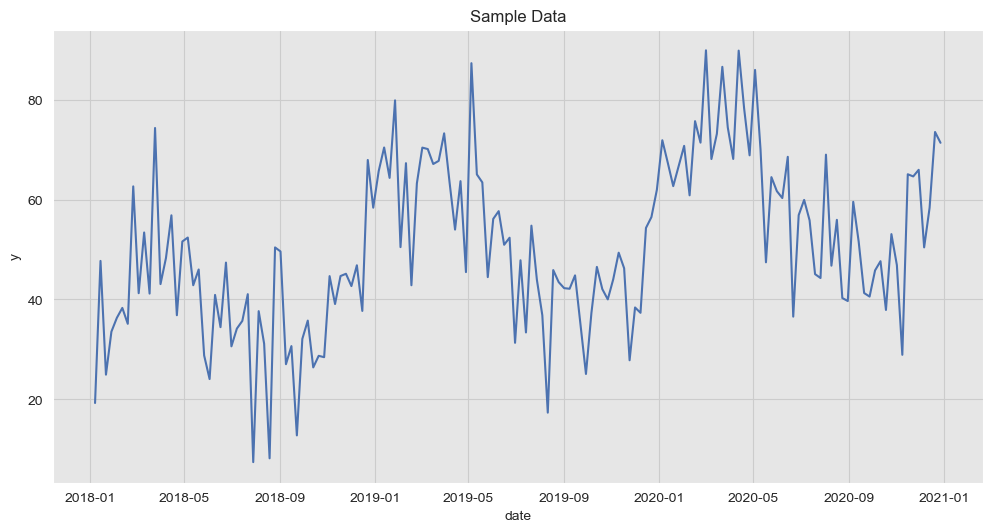

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=data_df, color=sns_c[0], ax=ax)
ax.set(title='Sample Data');

## Train-Test Split

We split our data intro a training and a test set (no random shuffle for time series data!).

In [4]:
threshold_date = '2020-01-04'

data_train_df = data_df.query(f'date < "{threshold_date}"')
data_test_df = data_df.query(f'date >= "{threshold_date}"')

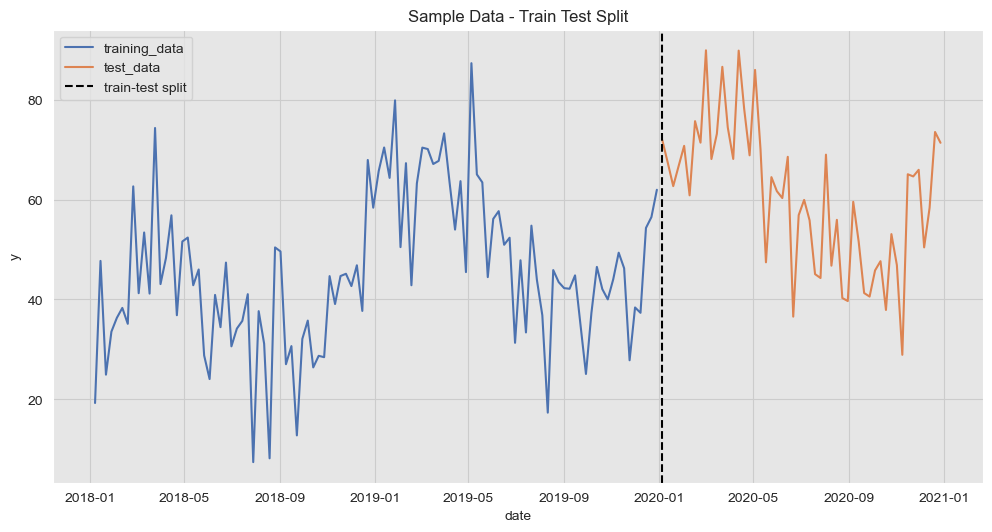

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=data_train_df, color=sns_c[0], label='training_data', ax=ax)
sns.lineplot(x='date', y='y', data=data_test_df, color=sns_c[1], label='test_data', ax=ax)
ax.axvline(x=threshold_date, color='black', linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='Sample Data - Train Test Split');

## Plot Features

A key component in the modeling workflow is to explore the relation between potential predictors and the target variable. There are many ways of doing this, one of them is data visualization. In the next plot we plot one feature ($x_1$) against the target variable $y$. Note that we can use a twin axis to plot them together even if they are on different scales. 

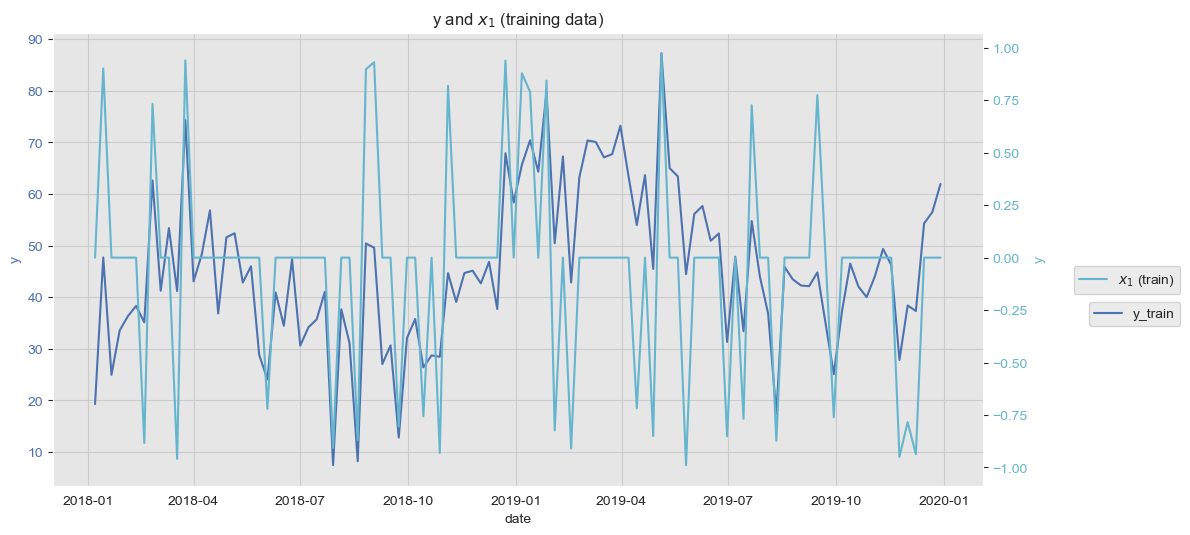

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x='date', y='y', data=data_train_df, color=sns_c[0], label='y_train', ax=ax1)
sns.lineplot(x='date', y='x1', data=data_train_df, color=sns_c[9], label=f'$x_1$ (train)', ax=ax2)
ax1.legend(bbox_to_anchor=(1.22, 0.42))
ax2.legend(bbox_to_anchor=(1.22, 0.5))
ax1.tick_params(axis='y', labelcolor=sns_c[0])
ax1.set_ylabel('y', fontdict={'color': sns_c[0]})
ax1.set(title=f'y and $x_1$ (training data)')
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[9])
ax2.set_ylabel('y', fontdict={'color': sns_c[9]});

Scatter plots are also very handy as we can encode various dimensions via color and size encoding.

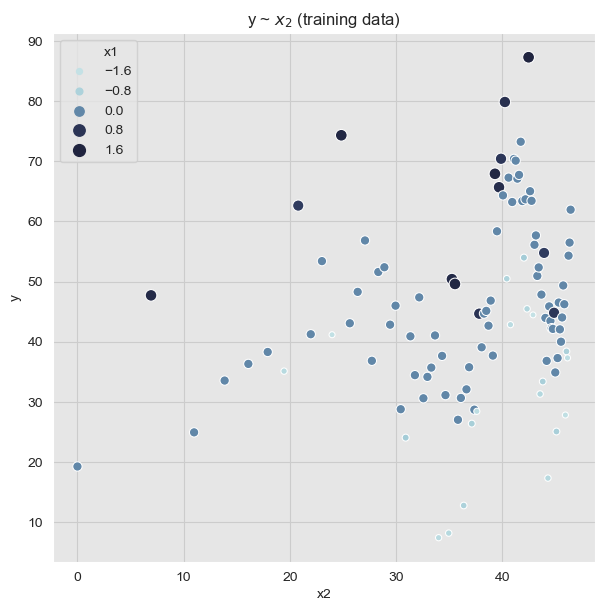

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))

cmap = sns.cubehelix_palette(rot=-0.2, as_cmap=True)

sns.scatterplot(
    x='x2', 
    y='y', 
    hue='x1', 
    size='x1',
    palette=cmap, 
    edgecolor='white', 
    data=data_train_df, 
    ax=ax
)
ax.legend(loc='upper left')
ax.set(title=r'y ~ $x_2$ (training data)');

Correlation analysis is another powerful technique to study potential predictors and to detect multicollinearity. We can use a [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) plot to represent the correlation matrix (see [here](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)).

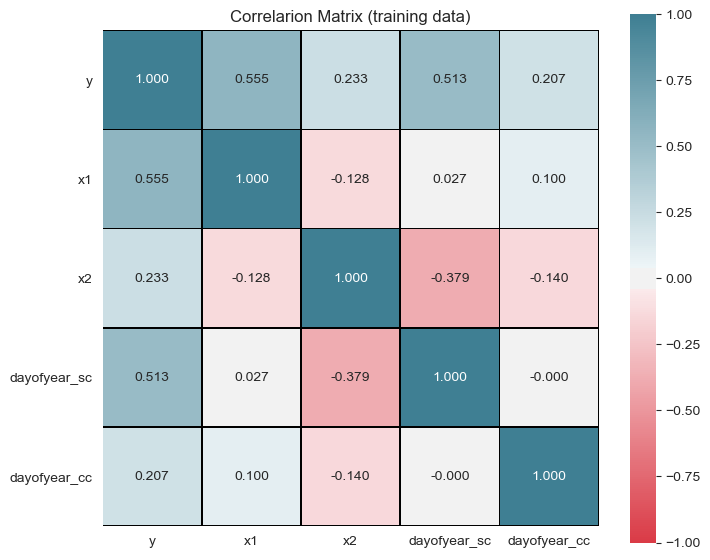

In [8]:
corr_mat = data_train_df.drop('date', axis=1).corr()

fig, ax = plt.subplots(figsize=(8, 7))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(
    data=corr_mat, 
    vmin=-1.0, 
    vmax=1.0, 
    center=0, 
    cmap=cmap, 
    square=True,
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_yticklabels(), horizontalalignment='center')
ax.set(title='Correlarion Matrix (training data)');

**Warning:** If the target variable has a trend and/or a strong seasonal pattern, it is a good practice to run a correlation analysis on each component of the time series decomposition, see for example the analysis on [this post](https://juanitorduz.github.io/intro_sts_tfp/).

In order to test for mulicollinearity (besides the one-to-one relation via correlation), we can compute the [Variance Inflation Factor](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) which is calculated *by taking the the ratio of the variance of all a given model's betas divide by the variance of a single beta if it were fit alone.*^[[https://etav.github.io/python/vif_factor_python.html](https://etav.github.io/python/vif_factor_python.html)] *A rule of thumb is that if $VIF(\beta_i)> 10 $ then multicollinearity is high.*^[[Wiki: Variance_inflation_factor](https://en.wikipedia.org/wiki/Variance_inflation_factor)]

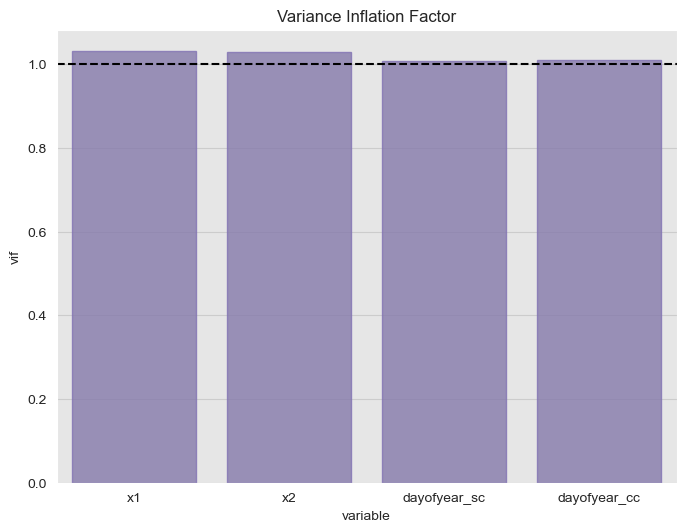

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train = data_train_df.drop(['y', 'date'], axis=1)

vif_df = pd.DataFrame(
    data= [ 
        (c, variance_inflation_factor(exog=X_train.to_numpy(), exog_idx=i)) 
        for i, c in enumerate(X_train.columns)
    ], 
    columns=['variable', 'vif']
)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    x='variable', 
    y='vif', 
    color=sns_c[4],
    edgecolor=sns_c[4],
    alpha=0.8,
    dodge=False,
    data=vif_df, 
    ax=ax
)

ax.axhline(y=1, color='black', linestyle='--')
ax.set(title='Variance Inflation Factor');

The all the values are close to one so there is no strong evidence of multicollinearity.

## Data Pre-Processing
As we want to run a linear model, it is very important to scale the features.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

target_variable = ['y']

date_features = ['date']

numeric_features = ['x1', 'x2', 'dayofyear_sc', 'dayofyear_cc']

preprocesser = ColumnTransformer(
    transformers=[('std', StandardScaler(), numeric_features)]
)
preprocesser.fit(data_train_df)

# Scale training data.
data_train_scaled_df = pd.DataFrame(
    data=preprocesser.transform(data_train_df),
    columns=numeric_features
)
data_train_scaled_df['y'] = data_train_df['y'] 

# Scale test data.
data_test_scaled_df = pd.DataFrame(
    data=preprocesser.transform(data_test_df),
    columns=numeric_features
)
data_test_scaled_df['y'] = data_train_df['y']

## Linear Model

Now we fit a linear model using  *R-like* formulas.

In [11]:
model_formula = 'y ~ x1 + x2 + dayofyear_sc + dayofyear_cc'
model = smf.ols(model_formula, data=data_train_scaled_df)
result = model.fit()
# Print linear model stats.
print(result.summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     211.6
Date:                Fri, 26 Jun 2020   Prob (F-statistic):           1.39e-47
Time:                        09:47:17   Log-Likelihood:                -312.92
No. Observations:                 104   AIC:                             635.8
Df Residuals:                      99   BIC:                             649.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.3816      0.493     92.085      0.000      44.404      46

## Predictions

Let us get the model predictions and confidence intervals (for both the mean and the observations).

In [12]:
# Predictions on the training set.
train_pred_df = result.get_prediction(data_train_scaled_df).summary_frame()
train_pred_df.columns = 'pred_' + train_pred_df.columns
train_pred_df = pd.concat([data_train_df, train_pred_df], axis=1)
train_pred_df = train_pred_df.assign(
    error = lambda x: x['pred_mean'] - x['y'],
    abs_error = lambda x: x['error'].abs(),
    p_error = lambda x: x['error'].div(x['y'])
)
# Predictions on the test set.
test_pred_df = result.get_prediction(data_test_scaled_df).summary_frame()
test_pred_df.columns = 'pred_' + test_pred_df.columns
test_pred_df = pd.concat([data_test_df.reset_index(drop=True), test_pred_df], axis=1)
test_pred_df = test_pred_df.assign(
    error = lambda x: x['pred_mean'] - x['y'],
    abs_error = lambda x: x['error'].abs(),
    p_error = lambda x: x['error'].div(x['y'])
)
# Concatenate predictions.
pred_df = pd.concat(
    [train_pred_df.assign(tag='train'), test_pred_df.assign(tag='test')], 
    axis=0
)

Now we plot the training fit and the prediction on the test set. In addition, we plot the confidence intervals on the prediction mean and on the observations.To make a difference between these two, we use the `alpha` parameter to modify the color transparency.

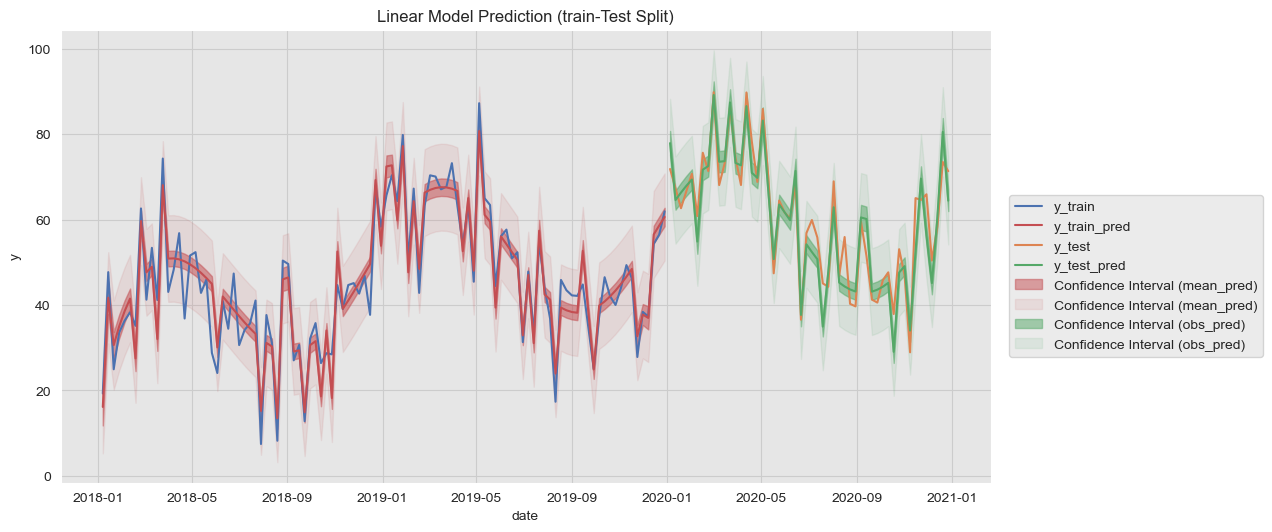

In [13]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=train_pred_df, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x='date', y='pred_mean', data=train_pred_df, color=sns_c[3], label='y_train_pred', ax=ax)
ax.fill_between(
    x=train_pred_df['date'],
    y1=train_pred_df['pred_mean_ci_lower'],
    y2=train_pred_df['pred_mean_ci_upper'],
    color=sns_c[3], 
    alpha=0.5,
    label='Confidence Interval (mean_pred)'
)
ax.fill_between(
    x=train_pred_df['date'],
    y1=train_pred_df['pred_obs_ci_lower'],
    y2=train_pred_df['pred_obs_ci_upper'],
    color=sns_c[3], 
    alpha=0.10,
    label='Confidence Interval (mean_pred)'
)
sns.lineplot(x='date', y='y', data=test_pred_df, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x='date', y='pred_mean', data=test_pred_df, color=sns_c[2], label='y_test_pred', ax=ax)
ax.fill_between(
    x=test_pred_df['date'],
    y1=test_pred_df['pred_mean_ci_lower'],
    y2=test_pred_df['pred_mean_ci_upper'],
    color=sns_c[2], 
    alpha=0.5,
    label='Confidence Interval (obs_pred)'
)
ax.fill_between(
    x=test_pred_df['date'],
    y1=test_pred_df['pred_obs_ci_lower'],
    y2=test_pred_df['pred_obs_ci_upper'],
    color=sns_c[2], 
    alpha=0.10,
    label='Confidence Interval (obs_pred)'
)
ax.legend(bbox_to_anchor=(1.3, 0.65))
ax.set(title='Linear Model Prediction (train-Test Split)', ylabel='y');

Another useful way to visualize the predictions is using a scatter plot them against the true values.

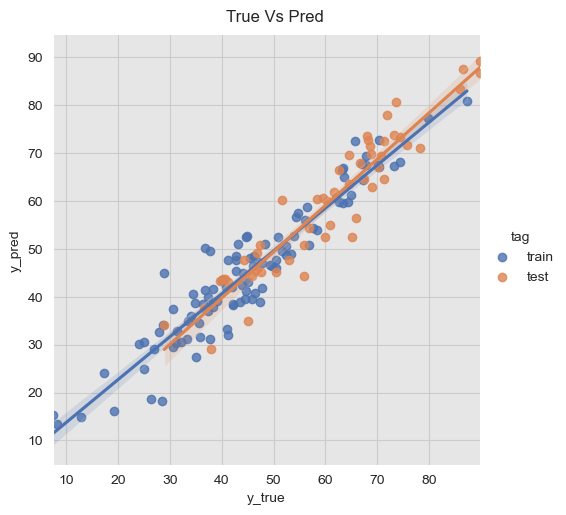

In [14]:
g = sns.lmplot(x='y', y ='pred_mean', data=pred_df, hue='tag')
g.fig.suptitle('True Vs Pred', y=1.02)
g.set_axis_labels('y_true', 'y_pred');

## Error Analysis

A crucial step in the model development/evaluation is the error analysis. Here we want to understand where the model is not doing well and see if there are hidden patterns which might inspire new features. In addition, we want to see if there are indicators of an overfit. For the later we can plot the (percent) errors distribution on the training and the test set.

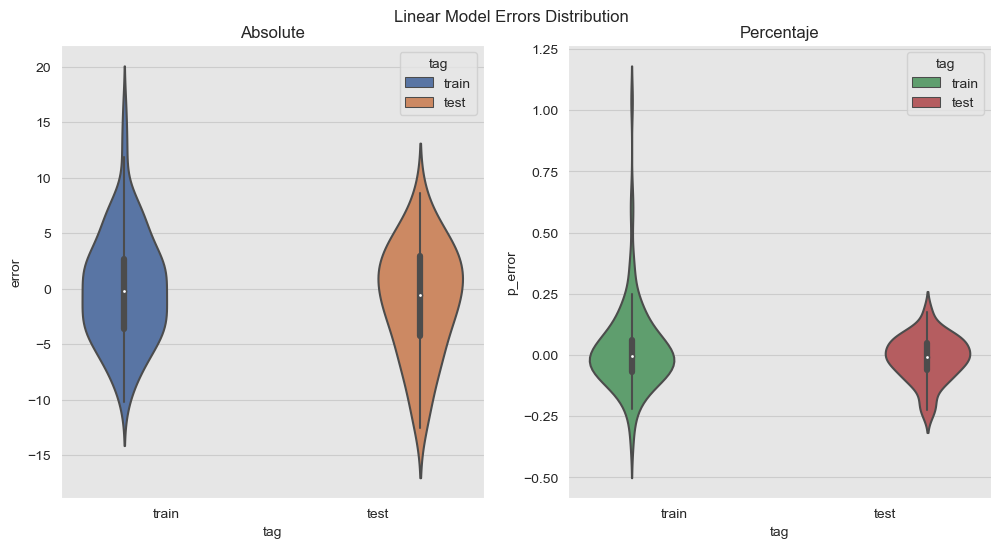

In [15]:
fig, ax = plt.subplots(1, 2)
sns.violinplot(x='tag', y='error', data=pred_df, hue='tag', palette=[sns_c[0], sns_c[1]], ax=ax[0])
sns.violinplot(x='tag', y='p_error', data=pred_df, hue='tag', palette=[sns_c[2], sns_c[3]], ax=ax[1])
ax[0].set(title='Absolute')
ax[1].set(title='Percentaje')
plt.suptitle(f'Linear Model Errors Distribution', y=0.94);

The distributions look comparable. Note however that there is point on which the percent error is very high:

In [16]:
pred_df.query('abs(p_error) > 1.0').T

,29
date,2018-07-29 00:00:00
y,7.45683
x1,-0.907099
x2,34.012
dayofyear_sc,-0.4515
dayofyear_cc,-0.892271
pred_mean,15.2096
pred_mean_se,1.26779
pred_mean_ci_lower,12.694
pred_mean_ci_upper,17.7252


In the next figure we represent the (percent) errors distributions in various ways: as a density an as a time series. In addition, we include the (partial) autocorrelation plots. These metrics are very useful to detect patterns on the errors. We also report the mape and wape error metrics. For a good model we want the errors to be [white noise](https://en.wikipedia.org/wiki/White_noise). I use this type of visualization to check model performance and to share the results. 

**Warning:** The code might look complicated and long. But bear with me! There are three main pars: (1) Define grid. (2) Add data and (3) Plot customization. It is probably a good idea to wrap it as a function(s) but in this notebook I want it to be quite verbose so that you can understand the role of each line. 

- Training Errors

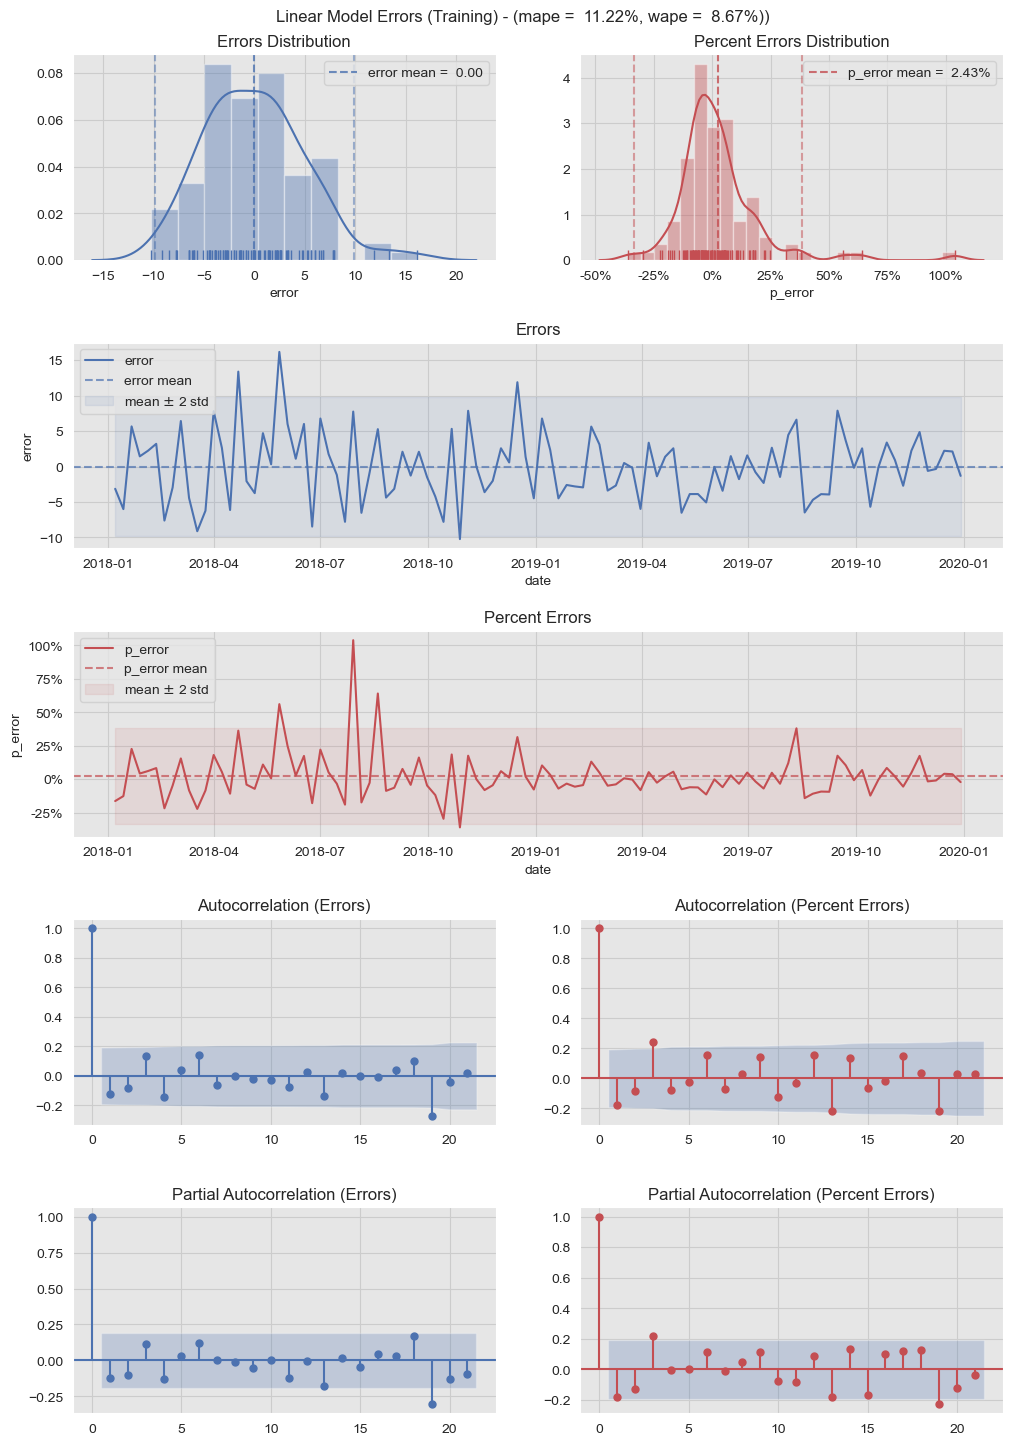

In [17]:
# Linear Model Error Plots. 
# Compute Errors Metrics.
error_mean = train_pred_df['error'].mean()
error_std = train_pred_df['error'].std()
p_error_mean = train_pred_df['p_error'].mean()
p_error_std = train_pred_df['p_error'].std()
mape = train_pred_df['p_error'].abs().mean()
wape = train_pred_df['error'].abs().sum() / train_pred_df['y'].abs().sum()
# Define plot grid.
fig = plt.figure(figsize=(12, 18), constrained_layout=True)
grid = plt.GridSpec(5, 2, hspace=0.4)
ax00 = fig.add_subplot(grid[0, 0])
ax01 = fig.add_subplot(grid[0, 1])
ax1 = fig.add_subplot(grid[1, :2])
ax2 = fig.add_subplot(grid[2, :2])
ax30 = fig.add_subplot(grid[3, 0])
ax31 = fig.add_subplot(grid[3, 1])
ax40 = fig.add_subplot(grid[4, 0])
ax41 = fig.add_subplot(grid[4, 1])
# Add data.
sns.distplot(a=train_pred_df['error'], color=sns_c[0], rug=True, ax=ax00)
ax00.axvline(x=error_mean, color=sns_c[0], linestyle='--', label=f'error mean = {error_mean: 0.2f}', alpha=0.8)
ax00.axvline(x=error_mean + 2*error_std, color=sns_c[0], linestyle='--', alpha=0.5)
ax00.axvline(x=error_mean - 2*error_std, color=sns_c[0], linestyle='--', alpha=0.5)
sns.distplot(a=train_pred_df['p_error'], color=sns_c[3], rug=True, ax=ax01)
ax01.axvline(x=p_error_mean , color=sns_c[3], linestyle='--', label=f'p_error mean = {p_error_mean: 0.2%}', alpha=0.8)
ax01.axvline(x=p_error_mean + 2*p_error_std, color=sns_c[3], linestyle='--', alpha=0.5)
ax01.axvline(x=p_error_mean - 2*p_error_std, color=sns_c[3], linestyle='--', alpha=0.5)
sns.lineplot(x='date', y='error', data=train_pred_df, color=sns_c[0], label='error', ax=ax1)
ax1.axhline(y=error_mean, color=sns_c[0], linestyle='--', label='error mean', alpha=0.7)
ax1.fill_between(
    x=train_pred_df['date'], 
    y1=error_mean - 2*error_std, 
    y2=error_mean + 2*error_std,
    color=sns_c[0],
    alpha=0.1,
    label=r'mean $\pm$ 2 std'
)
sns.lineplot(x='date', y='p_error', data=train_pred_df, color=sns_c[3], label='p_error', ax=ax2)
ax2.axhline(y=p_error_mean , color=sns_c[3], linestyle='--', label='p_error mean', alpha=0.7)
ax2.fill_between(
    x=train_pred_df['date'], 
    y1=p_error_mean - 2*p_error_std, 
    y2=p_error_mean + 2*p_error_std,
    color=sns_c[3],
    alpha=0.1,
    label=r'mean $\pm$ 2 std'
)
plot_acf(x=train_pred_df['error'], vlines_kwargs={'color': sns_c[0]}, color=sns_c[0], ax=ax30)
plot_acf(x=train_pred_df['p_error'], vlines_kwargs={'color': sns_c[3]}, color=sns_c[3], ax=ax31)
plot_pacf(x=train_pred_df['error'], vlines_kwargs={'color': sns_c[0]}, color=sns_c[0], ax=ax40)
plot_pacf(x=train_pred_df['p_error'], vlines_kwargs={'color': sns_c[3]}, color=sns_c[3], ax=ax41)
# Customization.
ax00.legend(loc='upper right')
ax00.set(title='Errors Distribution')
xvals01 = ax01.get_xticks()
ax01.set_xticklabels([f'{x:.0%}' for x in xvals01])
ax01.legend(loc='upper right')
ax01.set(title='Percent Errors Distribution')
ax1.legend(loc='upper left')
ax1.set(title='Errors')
yvals2 = ax2.get_yticks()
ax2.set_yticklabels([f'{x:.0%}' for x in yvals2])
ax2.legend(loc='upper left')
ax2.set(title='Percent Errors')
ax30.set(title='Autocorrelation (Errors)')
ax31.set(title='Autocorrelation (Percent Errors)')
ax40.set(title='Partial Autocorrelation (Errors)')
ax41.set(title='Partial Autocorrelation (Percent Errors)')
plt.suptitle(f'Linear Model Errors (Training) - (mape = {mape: 0.2%}, wape = {wape: 0.2%}))', y=0.905);

- Test Errors

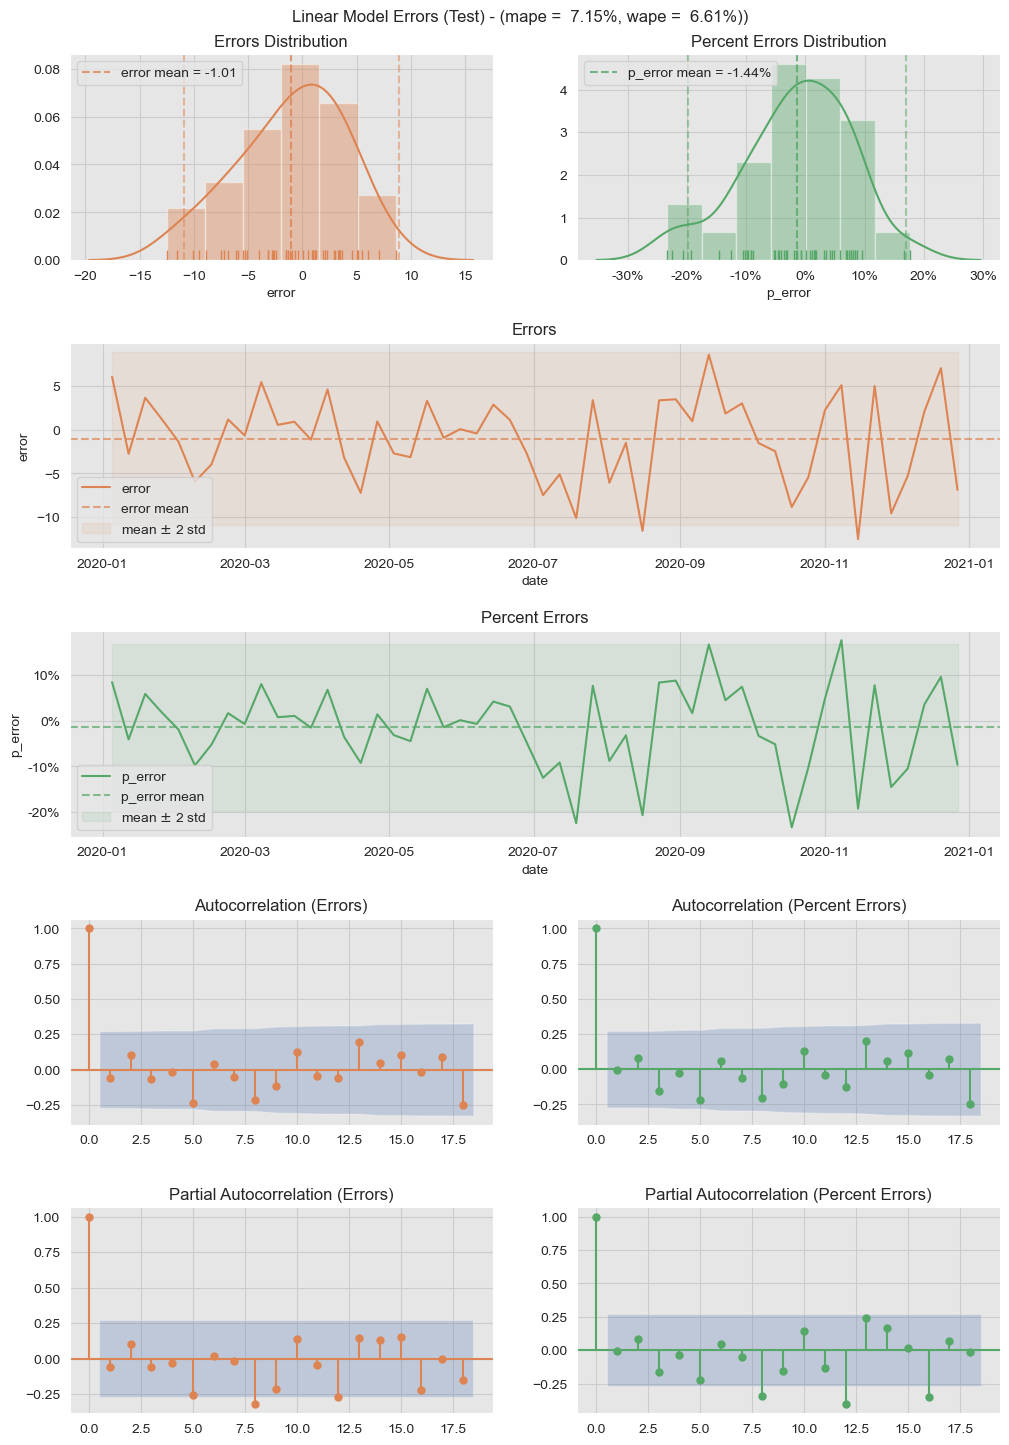

In [18]:
# Linear Model Error Plots.
# Compute Errors Metrics.
error_mean = test_pred_df['error'].mean()
error_std = test_pred_df['error'].std()
p_error_mean = test_pred_df['p_error'].mean()
p_error_std = test_pred_df['p_error'].std()
mape = test_pred_df['p_error'].abs().mean()
wape = test_pred_df['error'].abs().sum() / test_pred_df['y'].abs().sum()
# Define plot grid.
fig = plt.figure(figsize=(12, 18), constrained_layout=True)
grid = plt.GridSpec(5, 2, hspace=0.4)
ax00 = fig.add_subplot(grid[0, 0])
ax01 = fig.add_subplot(grid[0, 1])
ax1 = fig.add_subplot(grid[1, :2])
ax2 = fig.add_subplot(grid[2, :2])
ax30 = fig.add_subplot(grid[3, 0])
ax31 = fig.add_subplot(grid[3, 1])
ax40 = fig.add_subplot(grid[4, 0])
ax41 = fig.add_subplot(grid[4, 1])
# Add data.
sns.distplot(a=test_pred_df['error'], color=sns_c[1], rug=True, ax=ax00)
ax00.axvline(x=error_mean, color=sns_c[1], linestyle='--', label=f'error mean = {error_mean: 0.2f}', alpha=0.8)
ax00.axvline(x=error_mean + 2*error_std, color=sns_c[1], linestyle='--', alpha=0.5)
ax00.axvline(x=error_mean - 2*error_std, color=sns_c[1], linestyle='--', alpha=0.5)
sns.distplot(a=test_pred_df['p_error'], color=sns_c[2], rug=True, ax=ax01)
ax01.axvline(x=p_error_mean , color=sns_c[2], linestyle='--', label=f'p_error mean = {p_error_mean: 0.2%}', alpha=0.8)
ax01.axvline(x=p_error_mean + 2*p_error_std, color=sns_c[2], linestyle='--', alpha=0.5)
ax01.axvline(x=p_error_mean - 2*p_error_std, color=sns_c[2], linestyle='--', alpha=0.5)
sns.lineplot(x='date', y='error', data=test_pred_df, color=sns_c[1], label='error', ax=ax1)
ax1.axhline(y=error_mean, color=sns_c[1], linestyle='--', label='error mean', alpha=0.7)
ax1.fill_between(
    x=test_pred_df['date'], 
    y1=error_mean - 2*error_std, 
    y2=error_mean + 2*error_std,
    color=sns_c[1],
    alpha=0.1,
    label=r'mean $\pm$ 2 std'
)
sns.lineplot(x='date', y='p_error', data=test_pred_df, color=sns_c[2], label='p_error', ax=ax2)
ax2.axhline(y=p_error_mean , color=sns_c[2], linestyle='--', label='p_error mean', alpha=0.7)
ax2.fill_between(
    x=test_pred_df['date'], 
    y1=p_error_mean - 2*p_error_std, 
    y2=p_error_mean + 2*p_error_std,
    color=sns_c[2],
    alpha=0.1,
    label=r'mean $\pm$ 2 std'
)
plot_acf(x=test_pred_df['error'], vlines_kwargs={'color': sns_c[1]}, color=sns_c[1], ax=ax30)
plot_acf(x=test_pred_df['p_error'], vlines_kwargs={'color': sns_c[2]}, color=sns_c[2], ax=ax31)
plot_pacf(x=test_pred_df['error'], vlines_kwargs={'color': sns_c[1]}, color=sns_c[1], ax=ax40)
plot_pacf(x=test_pred_df['p_error'], vlines_kwargs={'color': sns_c[2]}, color=sns_c[2], ax=ax41)
# Customization.
ax00.legend(loc='upper left')
ax00.set(title='Errors Distribution')
xvals01 = ax01.get_xticks()
ax01.set_xticklabels([f'{x:.0%}' for x in xvals01])
ax01.legend(loc='upper left')
ax01.set(title='Percent Errors Distribution')
ax1.legend(loc='lower left')
ax1.set(title='Errors')
yvals2 = ax2.get_yticks()
ax2.set_yticklabels([f'{x:.0%}' for x in yvals2])
ax2.legend(loc='lower left')
ax2.set(title='Percent Errors')
ax30.set(title='Autocorrelation (Errors)')
ax31.set(title='Autocorrelation (Percent Errors)')
ax40.set(title='Partial Autocorrelation (Errors)')
ax41.set(title='Partial Autocorrelation (Percent Errors)')
plt.suptitle(f'Linear Model Errors (Test) - (mape = {mape: 0.2%}, wape = {wape: 0.2%}))', y=0.905);

Finally, we can use quantile plots to see who similar/different are the (percent) errors distributions. 

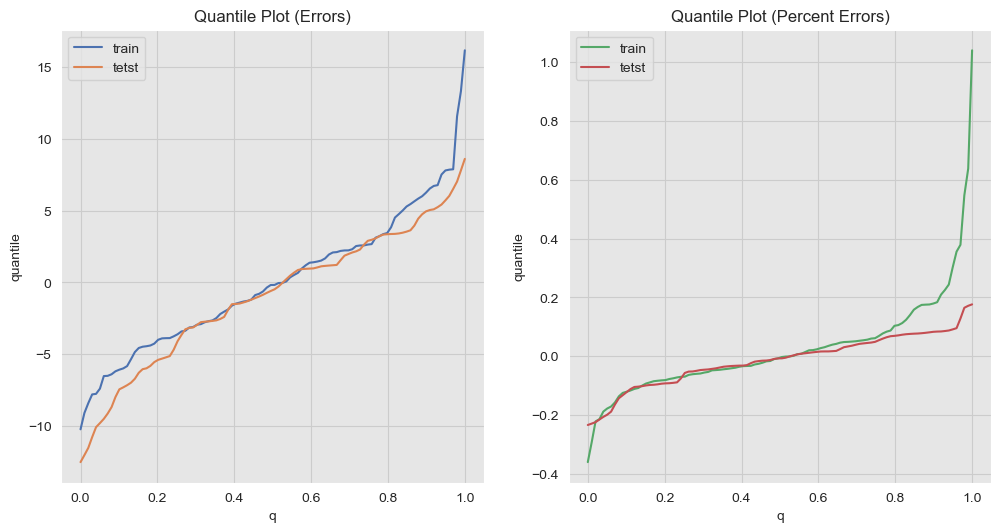

In [19]:
q_grid = np.linspace(start=0.0, stop=1.0, num=100)
train_error_quantiles = np.quantile(a=train_pred_df['error'], q=q_grid)
test_error_quantiles = np.quantile(a=test_pred_df['error'], q=q_grid)
train_p_error_quantiles = np.quantile(a=train_pred_df['p_error'], q=q_grid)
test_p_error_quantiles = np.quantile(a=test_pred_df['p_error'], q=q_grid)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(x=q_grid, y=train_error_quantiles, color=sns_c[0], label='train', ax=ax[0])
sns.lineplot(x=q_grid, y=test_error_quantiles, color=sns_c[1], label='tetst', ax=ax[0])
sns.lineplot(x=q_grid, y=train_p_error_quantiles, color=sns_c[2], label='train', ax=ax[1])
sns.lineplot(x=q_grid, y=test_p_error_quantiles, color=sns_c[3], label='tetst', ax=ax[1])
ax[0].legend(loc='upper left')
ax[0].set(title='Quantile Plot (Errors)', xlabel='q', ylabel='quantile')
ax[1].legend(loc='upper left')
ax[1].set(title='Quantile Plot (Percent Errors)', xlabel='q', ylabel='quantile');

Note for example that we can distinguish the long tail on the percent errors distribution of the training data (green line for $q>0.8$).

---
## Final Remarks

- The methods and plots presented in this notebook are of course not exhaustive of the types of analysis and diagnostics one can do in the context of regression analysis. 
- For an in-depth time series analysis model, one would run a time-slice cross-validation to estimate model performance (and not just one train-test split). 
- We have worked out some concrete examples which might be useful as references to use during the modeling cycle. 
- In addition, I have found in practice that these types of visualizations can be very effective in communicating results. 